In [1]:
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import time

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from tqdm import tqdm
from matplotlib.patches import Patch

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
df = pd.read_csv('result_all.csv')
# df.columns = ['NSC', 'drug', 'gene', 'num', 'num in journals']
df

,NSC,drug,gene,num,num in journals
0,740,METHOTREXATE,ATIC,58,44
1,740,METHOTREXATE,TYMS,65,0
2,740,METHOTREXATE,DHFR,300,210
3,740,METHOTREXATE,MIR330,0,0
4,740,METHOTREXATE,SNORD16,0,0
...,...,...,...,...,...
1340,791785,Sapacitabine,PGR,0,0
1341,791785,Sapacitabine,ZAP70,0,0
1342,791785,Sapacitabine,adenosine deaminase,0,0
1343,791785,Sapacitabine,EPHB6,0,0


In [3]:
n = dict(df[['NSC', 'drug']].values)
n

{740: 'METHOTREXATE',
 752: '6-THIOGUANINE',
 755: '6-MERCAPTOPURINE',
 762: 'Nitrogen mustard',
 1390: 'Allopurinol',
 1895: 'GUANAZOLE',
 3053: 'Actinomycin D',
 3088: 'Chlorambucil',
 6396: 'Thiotepa',
 8806: 'Melphalan',
 9706: 'Triethylenemelamine',
 14229: 'Acrichine',
 19893: 'Fluorouracil',
 24559: 'Mithramycin',
 25154: 'Pipobroman',
 26271: 'Cyclophosphamide',
 26980: 'Mitomycin',
 27640: 'Floxuridine',
 32065: 'Hydroxyurea',
 34462: 'Uracil mustard',
 38721: 'Mitotane',
 45388: 'DACARBAZINE',
 51143: 'Pyrazoloimidazole',
 56410: 'PORFIROMYCIN',
 63878: 'Cytarabine',
 63984: 'Cordycepin',
 71261: 'Beta-Thioguanine Deoxyriboside',
 71795: 'ELLIPTICINE',
 71851: 'A-TGdR',
 73754: 'Fluorodopan',
 77213: 'Procarbazine',
 79037: 'Lomustine',
 82151: 'Daunorubicin',
 83142: 'Daunorubicin',
 85998: 'STREPTOZOCIN',
 89201: 'Estramustine',
 94600: 'CAMPTOTHECIN',
 95382: 'Camptothecin Derivative',
 95441: 'METHYL CCNU',
 95466: 'PCNU',
 95678: '3-HP',
 100880: 'Camptothecin',
 102627:

In [4]:
# graphs = pmids[(pmids[0] == 759155) | (pmids[0] == 759263) | (pmids[0] == 100880) | (pmids[0] == 728073) | (pmids[0] == 83142)]
# graphs['Name'] = [n[i] for i in graphs[0]]
# graphs.columns = ['NSC', 'Gene', 'PIDs', 'Name']
# graphs = graphs[['NSC', 'Name', 'Gene', 'PIDs']]
# graphs = graphs.sort_values(['NSC', 'Name', 'Gene'])
# graphs

In [5]:
# graphs.reset_index(drop=True).to_csv('fig4_drug_gene_pids.csv')

In [6]:
df = df.sort_values('gene')
df

,NSC,drug,gene,num,num in journals
1135,753686,Olaparib,AKR1C3,1,1
1125,747856,Olaparib,AKR1C3,1,0
373,156303,M-AMSA,ALB,0,0
332,141540,Etoposide,ALB,10,0
1218,758230,Floxuridine,ALB,1,0
...,...,...,...,...,...
1083,736198,Indenoisoquinoline derivative,adenosine deaminase,0,0
653,355644,Anthrapyrazole derivative,adenosine deaminase,0,0
647,354646,Morpholinodoxorubicin,adenosine deaminase,0,0
884,643833,Camptothecin Derivative,adenosine deaminase,2,1


In [7]:
len(df['NSC'].unique())

269

In [8]:
len(df['drug'].unique())

172

In [9]:
len(df['gene'].unique())

134

# Alphabetical 

In [10]:
def get_small_size():
    bubble_data = df.groupby(['drug', 'gene'])['num'].sum().reset_index()
    bubble_data = bubble_data.sort_values('gene')

    pivot_table_data = bubble_data.pivot_table(values='num', index='drug', columns='gene', aggfunc='sum').fillna(0)
    pivot_table_data.index = list(pivot_table_data.index)
    pivot_table_data.columns = list(pivot_table_data.columns)
    pivot_table_data = pivot_table_data.loc[bubble_data['drug'].unique()]
    pivot_table_data = pivot_table_data.sort_index()
    pivot_table_data.index = pivot_table_data.index.str.capitalize()
    pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()

    pivot_table_data.columns = [i.replace('adenosine deaminase', 'ADA') for i in pivot_table_data.columns]
    # pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
    pivot_table_data = pivot_table_data.loc[pivot_table_data.sum(axis=1) != 0]
    # pivot_table_data = pivot_table_data.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
    pivot_table_data.index = pivot_table_data.index \
                                            .str.replace('2-n-methyl-6-thiaellipticinum iodide', 'NSC638066') \
                                            .str.replace('7-ethyl-10-hydroxycamptothecin', 'NSC673596') \
                                            .str.replace('6-mercaptopurine', 'Mercaptopurine') \
                                            .str.replace('6-thioguanine', 'Thioguanine') \
                                            .str.replace('8-chloro-adenosine', 'NSC354258') \
                                            .str.replace('Benzaldehyde (ben)', 'Benzaldehyde') 
    pivot_table_data = pivot_table_data.loc[sorted(pivot_table_data.index), sorted(pivot_table_data.columns)]

    t = pivot_table_data.copy()
    t = t*0
    tmp = dti.loc[list(set(dti.index) & set(pivot_table_data.index)), list(set(dti.columns) & set(pivot_table_data.columns))]
    k = np.sign(tmp.groupby(tmp.index).sum())
    t.loc[tmp.index, tmp.columns] = k

    log_scale_data = np.log1p(pivot_table_data[(t.sum(axis=1) != 0) | (pivot_table_data.sum(axis=1) != 0)])
    drugs = log_scale_data.index
    genes = log_scale_data.columns
    return drugs, genes

In [11]:
bubble_data = df.groupby(['drug', 'gene'])['num'].sum().reset_index()
bubble_data.gene = bubble_data.gene.replace('adenosine deaminase', 'ADA')
bubble_data = bubble_data.sort_values('gene')
bubble_data.drug = bubble_data.drug.str.capitalize()
bubble_data.drug = bubble_data.drug \
    .str.replace('2-n-methyl-6-thiaellipticinum iodide', 'NSC638066') \
    .str.replace('7-ethyl-10-hydroxycamptothecin', 'NSC673596') \
    .str.replace('6-mercaptopurine', 'Mercaptopurine') \
    .str.replace('6-thioguanine', 'Thioguanine') \
    .str.replace('8-chloro-adenosine', 'NSC354258') \
    .str.replace('Benzaldehyde (ben)', 'Benzaldehyde') 
bubble_data['existance'] = [1]*bubble_data.shape[0]
bubble_data = bubble_data.drop_duplicates()
bubble_data

,drug,gene,num,existance
806,Pyrazoloacridine,ADA,0,1
268,Cyclodisone,ADA,0,1
75,9-glycinamido-20(rs)-camptothecin hydrochloride,ADA,0,1
918,Uracil mustard,ADA,0,1
286,Camptothecin derivative,ADA,82,1
...,...,...,...,...
671,Mithramycin,ZAP70,0,1
658,Methoxycamptothecin,ZAP70,0,1
340,Cyanomorpholinodoxorubicin,ZAP70,0,1
697,Mitozolomide,ZAP70,0,1


In [12]:
pivot_table_data = bubble_data.pivot_table(values='num', index='drug', columns='gene', aggfunc='sum').fillna(0)
pivot_table_data.index = list(pivot_table_data.index)
pivot_table_data.columns = list(pivot_table_data.columns)
pivot_table_data = pivot_table_data.loc[bubble_data['drug'].unique()]
pivot_table_data = pivot_table_data.sort_index()
pivot_table_data = pivot_table_data.groupby(pivot_table_data.index).mean()
pivot_table_data

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-aminocamptothecin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-methylellpticinium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3-hp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yoshi 864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
existance = bubble_data.pivot_table(values='existance', index='drug', columns='gene', aggfunc='mean').fillna(0)
existance.index = list(existance.index)
existance.columns = list(existance.columns)
existance = existance.loc[bubble_data['drug'].unique()]
existance = existance.sort_index()
existance = existance.groupby(existance.index).mean()
existance

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10-aminocamptothecin,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2-methylellpticinium,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3-hp,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Yoshi 864,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
cols = sorted(existance.columns)
idxs = sorted(existance.index)

In [15]:
pivot_table_data = pivot_table_data.loc[idxs, cols]
existance = existance.loc[idxs, cols]

In [16]:
name = dict(pd.read_csv('nsc_cid_smiles_class_name.csv', index_col=0)[['NSC', 'NAME']].values)
dti = pd.read_csv('dti_drugbank.csv', index_col=0)
dti = np.sign(dti)
dti.index = [name[i] for i in dti.index]
dti.index = dti.index.str.capitalize()
dti = dti.loc[sorted(set(dti.index) & set(pivot_table_data.index)), sorted(set(dti.columns) & set(pivot_table_data.columns))]
dti = dti.drop_duplicates()

In [17]:
t = pivot_table_data.copy()
t = t*0
t.loc[dti.index, dti.columns] = dti
t

,ADA,AKR1C3,ALB,ALDH2,AR,ATIC,BLK,BMX,BTK,CA2,...,TLR8,TOP1,TOP1MT,TOP2A,TOP2B,TYMS,TYROBP,UGT1A1,XDH,ZAP70
"10,11-methylenedioxycamptothecin",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10-aminocamptothecin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-methylellpticinium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3-hp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5-fluoro deoxy uridine 10mer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xr-11576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Xr-5944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Yoshi 864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zalcitabine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
drugs, genes = get_small_size()

In [19]:
def create_comparison_matrix(predicted, known, drugs=None):
    # 結果のDataFrameを準備（既知のデータをコピーして使用）
    result = known.copy()
    for col in result.columns:
        result[col] = result[col].astype(str)  # 初期値の設定
        for idx in result.index:
            if predicted.at[idx, col] == 1 and known.at[idx, col] == 1:
                result.at[idx, col] = '♥'  # 予測も実際も1
            elif predicted.at[idx, col] == 1 and known.at[idx, col] == 0:
                result.at[idx, col] = '♣'  # 予測のみ1
            elif predicted.at[idx, col] == 0 and known.at[idx, col] == 1:
                result.at[idx, col] = '♦'  # 実際のみ1
            else:
                result.at[idx, col] = ''  # どちらも0
    
    if drugs is not None:
        result = result.loc[drugs]
        
    return result.values

# 比較マトリックスを生成
comparison_matrix = create_comparison_matrix(existance, t)

In [20]:
print('Both: ' + str(np.sum(comparison_matrix == '♥')))
print(f'Only predicted: ' + str(np.sum(comparison_matrix == '♣')))
print(f'Only dti: ' + str(np.sum(comparison_matrix == '♦')))

Both: 64
Only predicted: 902
Only dti: 3


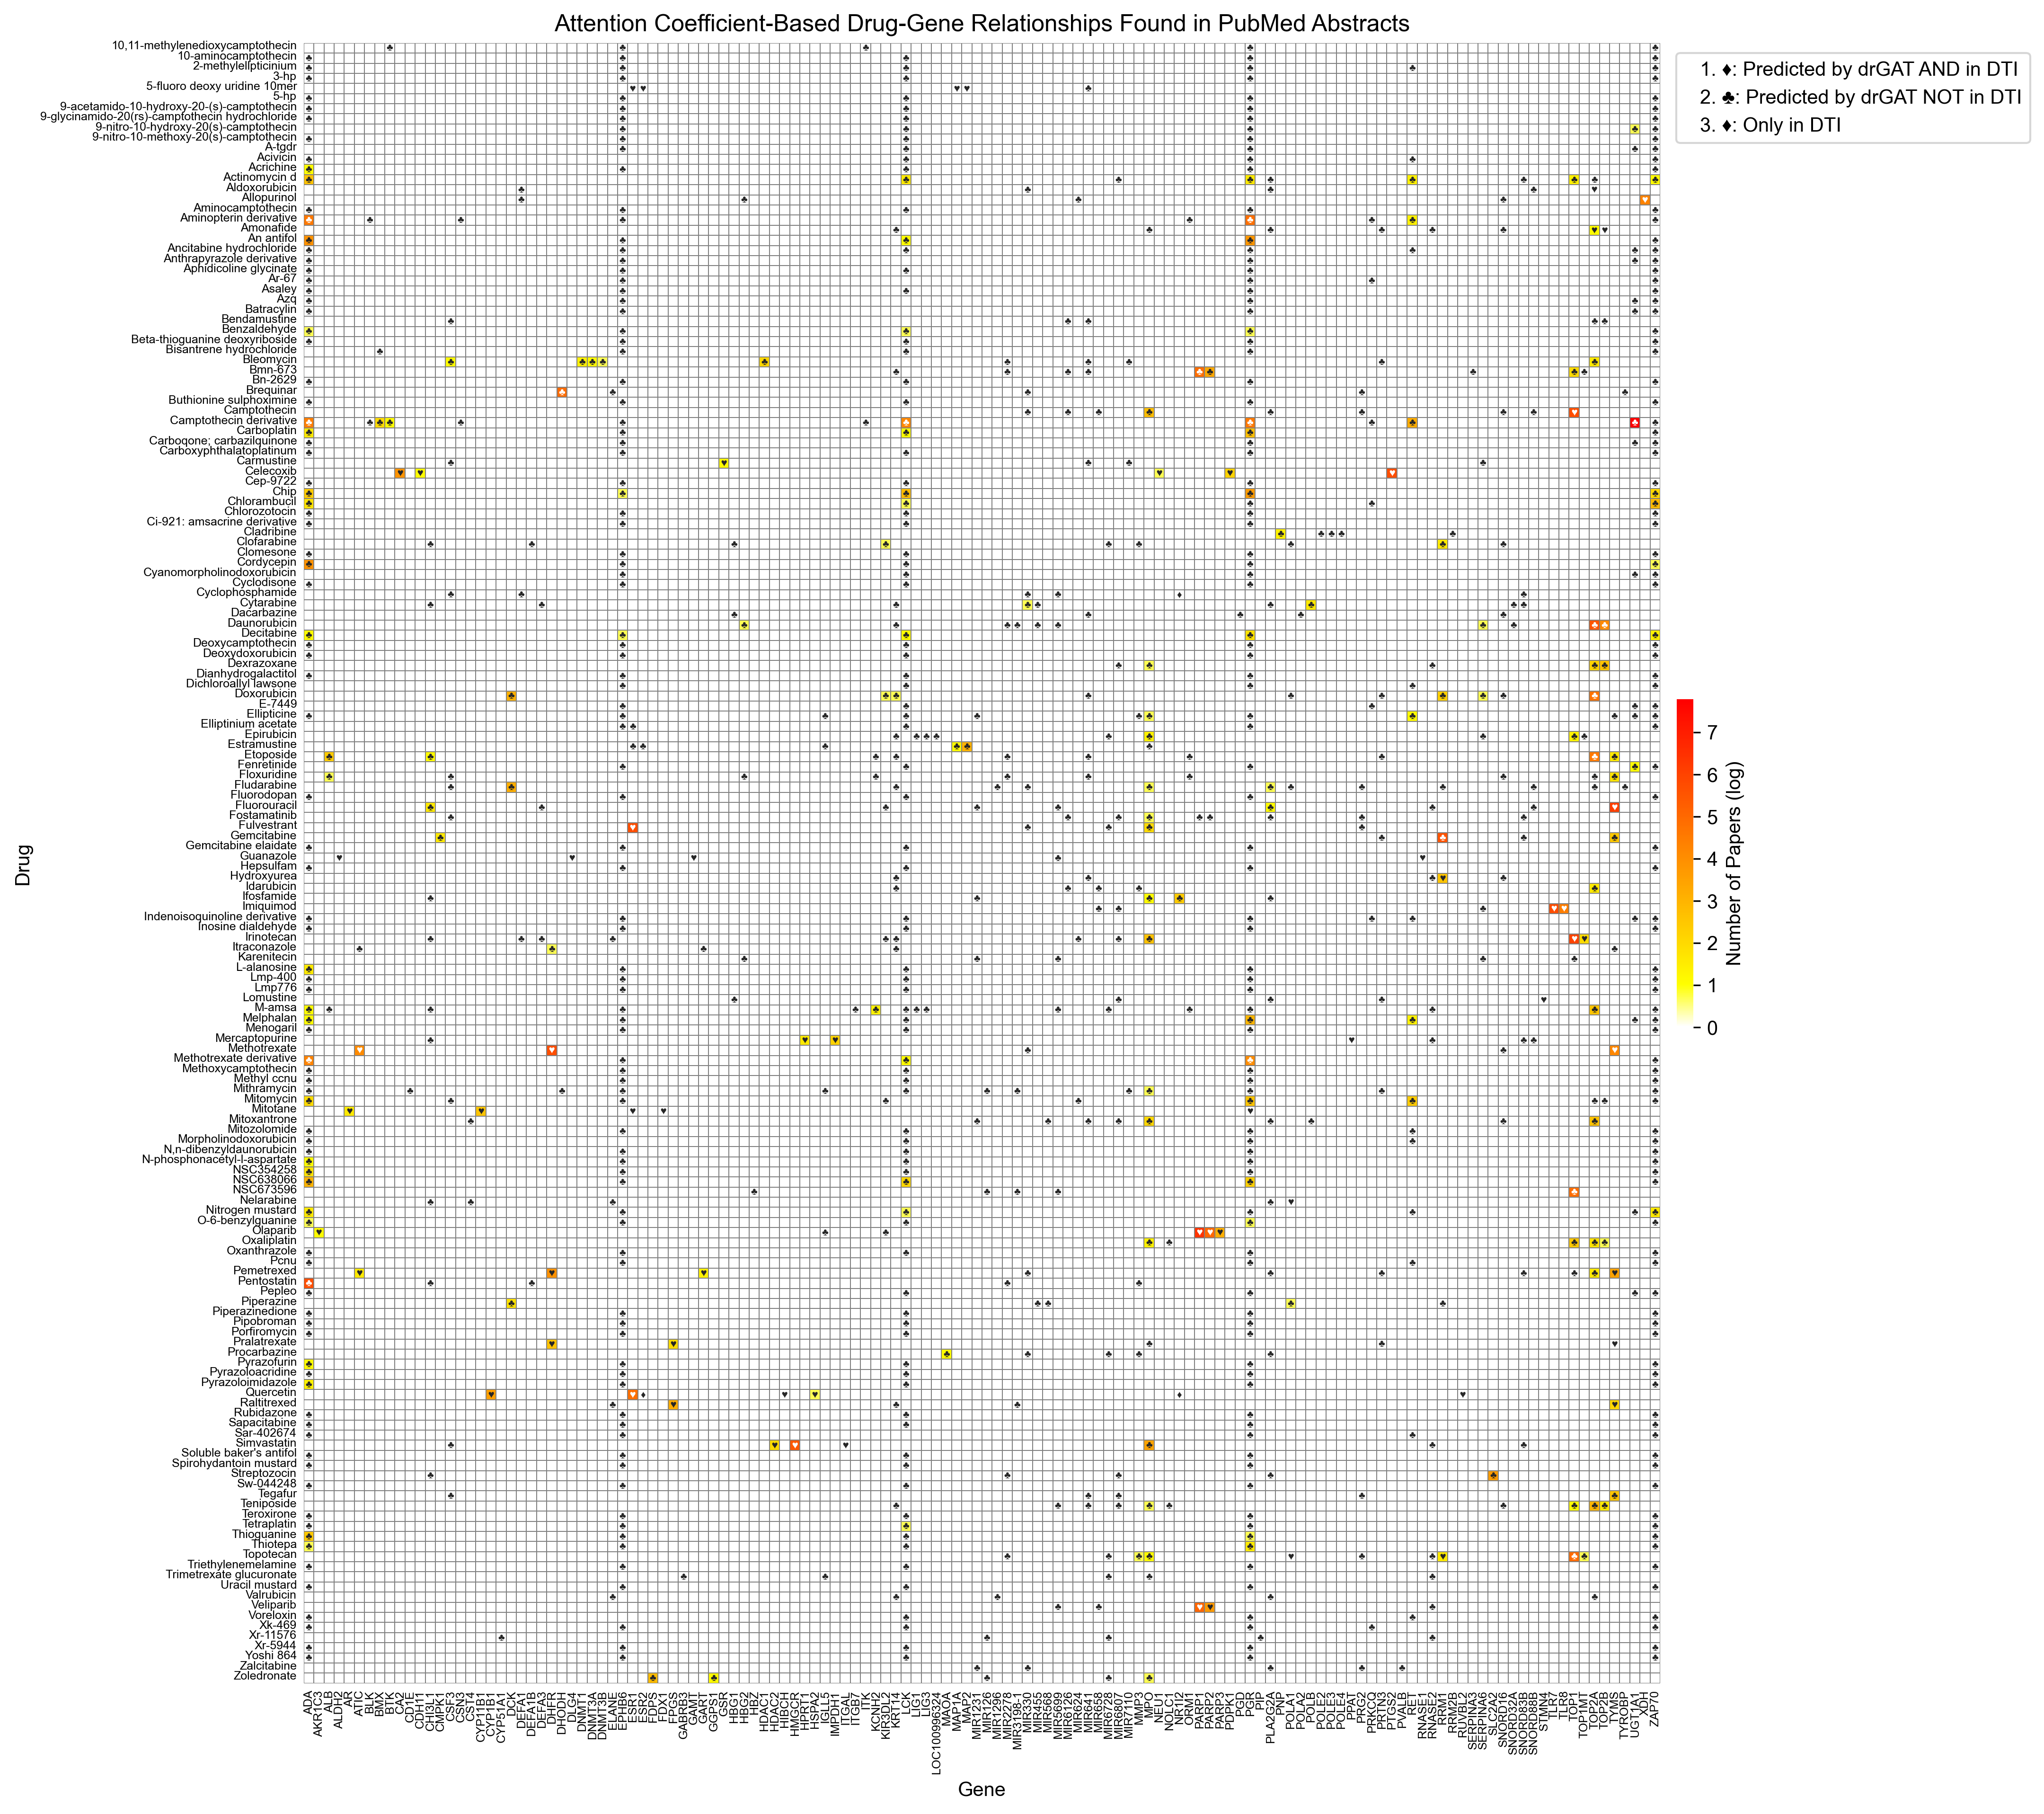

In [21]:
# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(30, 15), dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

logged = np.log1p(pivot_table_data)

max_val = np.max(logged)
cmap = LinearSegmentedColormap.from_list(
    "Custom cmap", 
    [(0, "white"), (1/max_val, "yellow"), (1, "red")], 
    N=256
)

# heatmap を描画
ax = sns.heatmap(
    logged,
    annot=comparison_matrix,
    fmt="",
    cmap=cmap,
    square=True,
    linewidths=0.1,
    cbar_kws={"label": "Number of Papers (log)", "shrink": 0.2, "pad": 0.005},
    linecolor="gray",
    annot_kws={
        #         'color': 'black',
        "size": 5
    },
)

ax.set_xticks(np.arange(pivot_table_data.shape[1]))
ax.set_yticks(np.arange(pivot_table_data.shape[0]))

y_ticks_positions = [tick + 0.3 for tick in ax.get_yticks()]  # Adjust 0.3 as needed
ax.set_yticks(y_ticks_positions)

ax.set_xticklabels(pivot_table_data.columns)
ax.set_yticklabels(pivot_table_data.index)

ax.tick_params(axis="x", which="major", labelsize=6, length=0)
ax.tick_params(axis="y", which="major", labelsize=6, length=0)

# Adding a legend
legend_elements = [
    Patch(facecolor="none", edgecolor="none", label="1. ♦: Predicted by drGAT AND in DTI"),
    Patch(facecolor="none", edgecolor="none", label="2. ♣: Predicted by drGAT NOT in DTI"),
    Patch(facecolor="none", edgecolor="none", label="3. ♦: Only in DTI"),
]
ax.legend(
    handles=legend_elements,
    loc="upper right",
    bbox_to_anchor=(1.28, 1),
    frameon=True,
    handlelength=0,
    handleheight=0,
    labelspacing=0.5,
    fontsize=10, 
)


plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.xlabel("Gene")
plt.ylabel("Drug")
plt.title(
    "Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts"
)
plt.savefig("output.pdf")
plt.show()

# Smaller version

Both: 53
Only predicted: 495
Only dti: 2


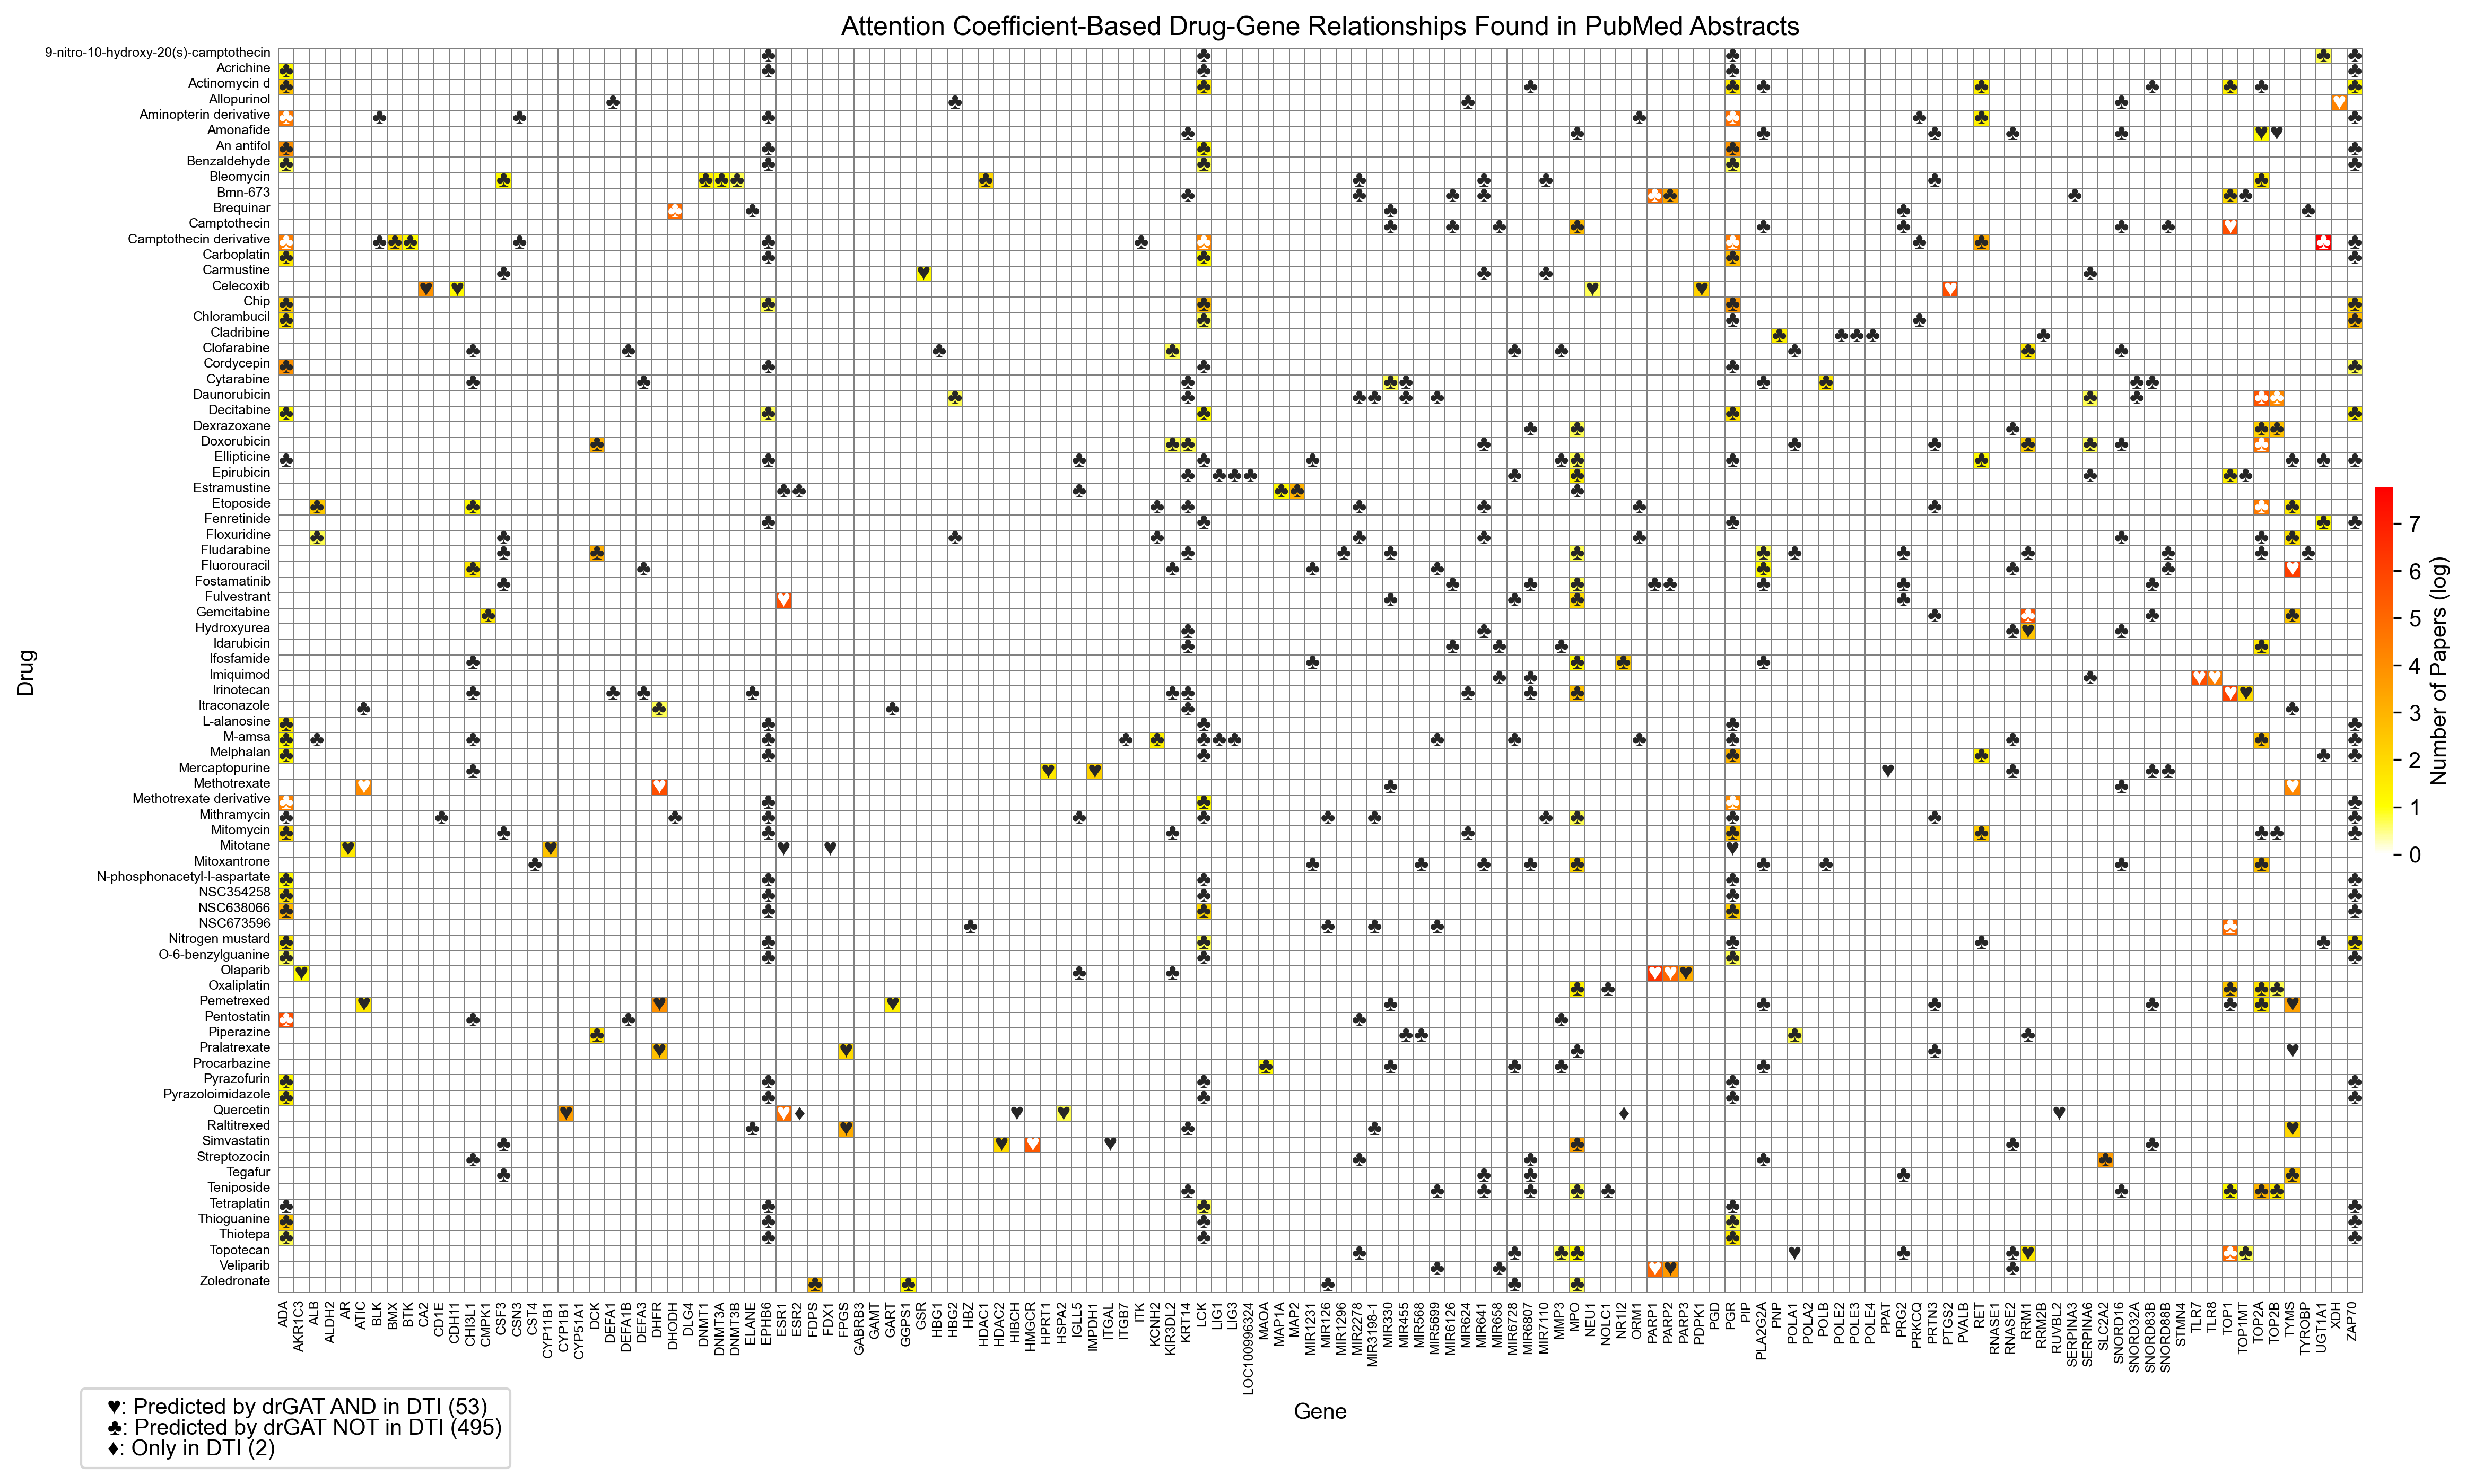

In [22]:
# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(20, 15), dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

logged = np.log1p(pivot_table_data.loc[drugs])
comparison_matrix = create_comparison_matrix(existance, t, drugs)

both = str(np.sum(comparison_matrix == '♥'))
print('Both: ' + both)
predict = str(np.sum(comparison_matrix == '♣'))
print(f'Only predicted: ' + predict)
dti = str(np.sum(comparison_matrix == '♦'))
print(f'Only dti: ' + dti)

max_val = np.max(logged)
cmap = LinearSegmentedColormap.from_list(
    "Custom cmap", 
    [(0, "white"), (1/max_val, "yellow"), (1, "red")], 
    N=256
)

# heatmap を描画
ax = sns.heatmap(
    logged,
    annot=comparison_matrix,
    fmt="",
    cmap=cmap,
    square=True,
    linewidths=0.1,
    cbar_kws={"label": "Number of Papers (log)", "shrink": 0.2, "pad": 0.005},
    linecolor="gray",
#     annot_kws={
#         #         'color': 'black',
#         "size": 5
#     },
)

ax.set_xticks(np.arange(logged.shape[1]))
ax.set_yticks(np.arange(logged.shape[0]))

y_ticks_positions = [tick + 0.3 for tick in ax.get_yticks()]  # Adjust 0.3 as needed
ax.set_yticks(y_ticks_positions)

ax.set_xticklabels(logged.columns)
ax.set_yticklabels(logged.index)

ax.tick_params(axis="x", which="major", labelsize=6, length=0)
ax.tick_params(axis="y", which="major", labelsize=6, length=0)

# Adding a legend
legend_elements = [
    Patch(facecolor="none", edgecolor="none", label=f"♥: Predicted by drGAT AND in DTI ({both})"),
    Patch(facecolor="none", edgecolor="none", label=f"♣: Predicted by drGAT NOT in DTI ({predict})"),
    Patch(facecolor="none", edgecolor="none", label=f"♦: Only in DTI ({dti})"),
]
ax.legend(
    handles=legend_elements,
    loc='lower left',
    bbox_to_anchor=(-0.1, -0.15),
    frameon=True,
    handlelength=0,
    handleheight=0,
    labelspacing=0,
    fontsize=10, 
)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
plt.xlabel("Gene")
plt.ylabel("Drug")
plt.title(
    "Attention Coefficient-Based Drug-Gene Relationships Found in PubMed Abstracts"
)
plt.savefig("output.pdf")
plt.show()